In [1]:
import sys
import os
import itertools

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits import mplot3d
from sklearn.decomposition import PCA


import pandas as pd

sys.path.append("../../ndsvae/")
import ndsvae as ndsv

sys.path.append("../")
import util
import plotutils as pu
import dsa

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
config = "ns_3_mreg_3_msub_0_nf_32"
conn = "linw"
preproc = "dicer"
modelname = "AB"

ds = ndsv.Dataset.from_file(f"../run/hcp/hcp100_{conn}_{preproc}/dataset.npz")
run = util.select_run_fc(f"hcp100_{conn}_{preproc}", modelname, config, [0,1], "hcp")
direc = f"../run/hcp/hcp100_{conn}_{preproc}/model{modelname}/{config}/run{run:02d}"
params = util.load_params(os.path.join(direc, "parameters"), np.r_[:100])

model = util.get_model(modelname, config, ds)
model.load_weights(f"../run/hcp/hcp100_{conn}_{preproc}/model{modelname}/{config}/run{run:02d}/fit/model")

2022-08-29 18:20:48.614285: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-29 18:20:48.638473: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 3399905000 Hz
2022-08-29 18:20:48.639256: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x561cad0b05f0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-08-29 18:20:48.639272: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-08-29 18:20:48.639402: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [3]:
nsub, nreg, _, nt = ds.y.shape

## Analyze and simulate

In [4]:
# Set seed for repeatability
np.random.seed(42)

In [5]:
# Node: fixed point and eigenvalues

thetareg = np.zeros(model.mreg)
thetasub = np.zeros(model.msub)
u  = 0.
us = 0.

xf_node, _, ev_node, _ = dsa.find_fixed_points_node(model, thetareg=thetareg, thetasub=thetasub, u=u, us=us,
                                                    n=5, init_range=(-2,2))

len(xf_node)

1

In [6]:
# Node: Simulated trajectories

t_node, x_node, _, _, _ = dsa.find_attractors_node(model, thetareg, thetasub, u=u, us=us, n=30, init_range=(-2,2),
                                                   T1=100, T2=1000, max_step=0.1)

t_node.shape, x_node.shape                                                        

((1002,), (30, 3, 1002))

In [7]:
# Network: Fixed point and eigenvalues
isub = 3

thetareg = np.random.normal(params.thetareg[isub,:,:,0], params.thetareg[isub,:,:,1])
thetasub = np.zeros(model.msub)
us = 0.

xf_network, _, ev_network, _ = dsa.find_fixed_points_network(model, ds.w[isub], 
                                                            thetareg=thetareg, thetasub=thetasub,
                                                            us=us, n=5, init_range=(-2,2))

len(xf_network)

1

In [8]:
# Network: Simulated trajectories

t_network, x_network, _, _, _ = dsa.find_attractors_network(model, ds.w[isub], thetareg, thetasub, us=us, n=30,
                                                            init_range=(-2,2), T1=100, T2=1000, max_step=0.1)


## Load previous data

In [9]:
! ls res

df_at.csv  functional_connectivity.csv	subj_fp.csv
df_fp.csv  subj_at.csv			subj_fp.npz


In [10]:
df1s = pd.read_csv("res/df_fp.csv")
df2s = pd.read_csv("res/df_at.csv")

df1n = pd.read_csv("res/subj_fp.csv")
df2n = pd.read_csv("res/subj_at.csv")

fpn = np.load("res/subj_fp.npz")['fixed_points']

In [11]:
for isub_ in range(nsub):
    for irand in range(4):
        dff = df1n[(df1n.isub == isub_) & (df1n.irand == irand)]
        if np.any(dff.n > 0) or np.any(~dff.stable):            
            print(f"Subject {isub_}, init {irand}")
            
            for i, (_, row) in enumerate(dff.iterrows()):
                print(f"    FP{i}: {'Stable' if row.stable else 'Unstable'}")
    
            ifps = dff.ifp.to_list()
            for i, ifp1 in enumerate(ifps):
                for j, ifp2 in enumerate(ifps[:i]):
                    x1 = fpn[ifp1]
                    x2 = fpn[ifp2]
                    l2 = np.linalg.norm(x1-x2)
                    linf = np.linalg.norm(x1-x2, ord=np.inf)
                    print(f"    Distance FP{j}-FP{i}: L2 {l2:8.5f}   Linf {linf:8.5f}")

            print("")

Subject 3, init 0
    FP0: Stable
    FP1: Unstable
    FP2: Stable
    Distance FP0-FP1: L2  0.05016   Linf  0.05369
    Distance FP0-FP2: L2  0.05056   Linf  0.05427
    Distance FP1-FP2: L2  0.00065   Linf  0.00058

Subject 11, init 3
    FP0: Stable
    FP1: Stable
    FP2: Unstable
    Distance FP0-FP1: L2  0.13174   Linf  0.10531
    Distance FP0-FP2: L2  0.07230   Linf  0.05757
    Distance FP1-FP2: L2  0.05984   Linf  0.04774

Subject 45, init 1
    FP0: Stable
    FP1: Stable
    Distance FP0-FP1: L2  0.17926   Linf  0.14978

Subject 45, init 2
    FP0: Stable
    FP1: Stable
    FP2: Unstable
    Distance FP0-FP1: L2  0.17318   Linf  0.15170
    Distance FP0-FP2: L2  0.08815   Linf  0.07504
    Distance FP1-FP2: L2  0.08545   Linf  0.07855

Subject 45, init 3
    FP0: Stable
    FP1: Stable
    FP2: Unstable
    Distance FP0-FP1: L2  0.65496   Linf  0.57131
    Distance FP0-FP2: L2  0.08155   Linf  0.08007
    Distance FP1-FP2: L2  0.57556   Linf  0.49128

Subject 73, init 1


In [12]:
node_frac_monostable  = sum(df1s.groupby(['iconf']).size() == 1) / df1s.iconf.nunique()
node_frac_multistable = sum(df1s.groupby(['iconf']).size() > 1) / df1s.iconf.nunique()
node_frac_nonstat = df2s.has_nonconverging.mean()

In [13]:
dff = df1n.groupby(["isub", "irand"]).agg({"n": "count"}).groupby("isub").agg({"n": "max"}).reset_index()
network_n_monostable  = sum(dff.n == 1)
network_n_multistable = sum(dff.n > 1)
network_n_nonstat = sum(df2n.groupby("isub").agg({"has_nonconverging": "any"}).has_nonconverging)

## Plotting functions

In [20]:
def plot_3d(ax, x, x0, highlight, labels=None):
    n = len(x)    

    for i in range(n):
        color, alpha, lw, zorder = ('0.4', 0.7, 1, 5) if i != highlight else ('tab:red' , 1., 1.5, 8)
        ax.plot(x[i,0], x[i,1], x[i,2], color=color, zorder=zorder, alpha=alpha, lw=lw)
        ax.scatter(x[i,0,0], x[i,1,0], x[i,2,0], color=color, alpha=alpha, s=8, marker='^')

    ax.scatter(x0[0], x0[1], x0[2], color='k', s=40, zorder=15)
    
    ax.tick_params(labelsize=8, pad=0)
    ax.view_init(elev=10, azim=30,)
    ax.set_xticks([-2, 0, 2])
    ax.set_yticks([-2, 0, 2])
    ax.set_zticks([-2, 0, 2])
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    
    if labels is None:
        labels = ["$x_{1}$", "$x_{2}$", "$x_{3}$"]
    
    ax.set_xlabel(labels[0], labelpad=0)
    ax.set_ylabel(labels[1], labelpad=0)
    ax.set_zlabel(labels[2], labelpad=0)
    
    
def plot_eigenvalues(ax, eigenvalues, **args):
    plt.sca(ax)
    
    plt.scatter(eigenvalues.real, 10*eigenvalues.imag, color='k', zorder=5, **args)
    
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.xticks([-1, 0, 1])
    plt.yticks([-1, 0, 1], [-0.1, 0., 0.1])
    # plt.ylim(-0.15, 0.15)
    
    if np.any(np.abs(eigenvalues.real) > 1.5) or np.any(np.abs(eigenvalues.imag) > 0.15):
        print("Limits unsufficient!")
    
    plt.grid()
    plt.xlabel("Re($\\lambda$)")
    plt.ylabel("Im($\\lambda$)")
    
def plot_bars(ax, values, percents=False, ylabel=None):
    bars = plt.bar([0,1,2], values)
    plt.xticks([0, 1, 2], ["Mono-\nstable", "Multi-\nstable", "Un-\nsteady"])
    
    if percents:
        plt.yticks([0, 50, 100], ["0%", "50%", "100%"])
        ax.bar_label(bars, fmt='%g%%')
    else:
        plt.yticks([0, 50, 100])
        ax.bar_label(bars, fmt='%g')
        
    if ylabel is not None:
        plt.ylabel(ylabel)
        
    plt.ylim(0, 120)
    pu.bottomleft_spines(ax)

## Figure

In [21]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Arial"

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

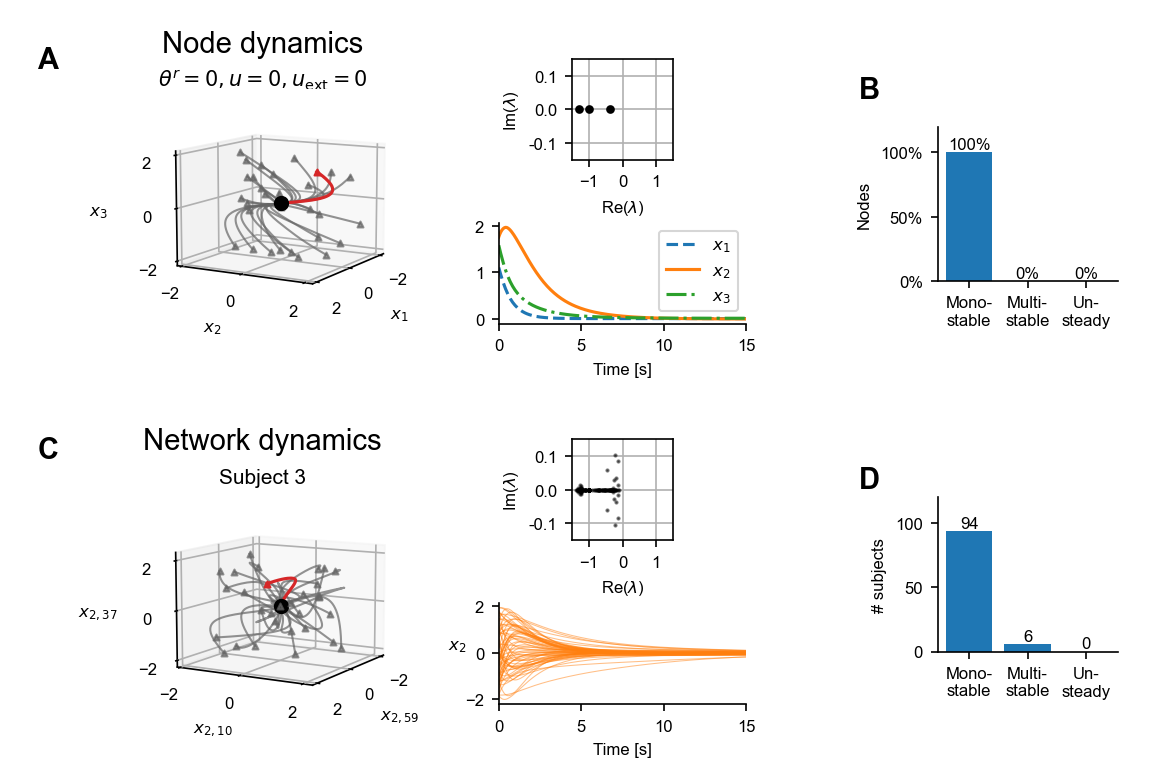

In [22]:
FS = 0.72

fig = plt.figure(figsize=(7.5, 5), dpi=150)

gs0 = GridSpec(nrows=2, ncols=1, hspace=0.7, left=0.05, bottom=0.05, top=0.9, right=0.42)
gs1 = GridSpec(nrows=5, ncols=1, hspace=0.8, wspace=0.0, height_ratios=(1,1,-0.1,1,1),
              left=0.43, bottom=0.08, top=0.94, right=0.65)

gs2 = GridSpec(nrows=2, ncols=1, hspace=1.4, left=0.82, bottom=0.15, top=0.85, right=0.98)

# Node dynamics
irand = 12

ax = plt.subplot(gs0[0], projection='3d')
plot_3d(ax, x_node[:30], xf_node[0], highlight=irand)


ax = plt.subplot(gs1[1])
plt.plot(FS*t_node, x_node[irand,0,:], label="$x_1$", ls='--')
plt.plot(FS*t_node, x_node[irand,1,:], label="$x_2$", ls='-')
plt.plot(FS*t_node, x_node[irand,2,:], label="$x_3$", ls='-.')
plt.legend(fontsize=8)
plt.xlim(0, 15)
plt.xlabel("Time [s]")
# plt.ylabel("$x$", rotation=0)
pu.bottomleft_spines(ax)

ax = plt.subplot(gs1[0], aspect='equal')
plot_eigenvalues(ax, ev_node[0], s=10)


ax = plt.subplot(gs2[0])
plot_bars(ax, 100*np.array([node_frac_monostable, node_frac_multistable, node_frac_nonstat]),
          percents=True, ylabel="Nodes")



# Network dynamics
irand = 7

ax = plt.subplot(gs0[1], projection='3d')
iregs = [59,10,37]
xn = np.array([x_network[i][iregs,1,:200] for i in range(30)])
plot_3d(ax, xn, xf_network[0,iregs,1], highlight=irand,
        labels=[f"$x_{{2,{iregs[0]}}}$", f"$x_{{2,{iregs[1]}}}$", f"$x_{{2,{iregs[2]}}}$"])


ax = plt.subplot(gs1[4])
for i in range(nreg):
    plt.plot(FS*t_network[irand], x_network[irand][i,1,:], color='tab:orange', lw=0.5, alpha=0.5)
# plt.legend(fontsize=8)
plt.xlim(0, 15)
plt.xlabel("Time [s]")
plt.ylabel("$x_2$", rotation=0)
pu.bottomleft_spines(ax)


ax = plt.subplot(gs1[3], aspect='equal')
plot_eigenvalues(ax, ev_network[0], s=1, alpha=0.5)

ax = plt.subplot(gs2[1])
plot_bars(ax, np.array([network_n_monostable, network_n_multistable, network_n_nonstat]), ylabel="# subjects")


bg = pu.Background(visible=False)
bg.axes.text(0.22, 0.96, "Node dynamics",    ha='center', va='center', fontsize=14)
bg.axes.text(0.22, 0.912, r"${\theta}^r = 0, u = 0, u_\mathrm{ext} = 0$", ha='center', va='center',
             fontsize=10, zorder=30)


bg.axes.text(0.22, 0.43, "Network dynamics", ha='center', va='center', fontsize=14)
bg.axes.text(0.22, 0.382, f"Subject {isub}", ha='center', va='center', fontsize=10, zorder=30)

# bg.add_labels([0.02, 0.38, 0.75, 0.02, 0.38, 0.75], [0.92, 0.92, 0.88, 0.40, 0.40, 0.36])
bg.add_labels([0.02, 0.75, 0.02, 0.75], [0.92, 0.88, 0.40, 0.36], fontsize=14)
plt.savefig("img/Fig_DynSys.pdf")